In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install matplotlib seaborn scikit-learn pandas-plink
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_plink import read_plink1_bin
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import scipy.stats as stats


In [3]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [4]:
# Load Data
data_prefix = "/content/drive/MyDrive/2025Fall_Biostats_Hw1_data/ADAPTmap_genotypeTOP_20160222_full"
bed_file = data_prefix + '.bed'

try:
    print("Loading PLINK data...")
    print(f"BED file: {bed_file}")
    goat_data = read_plink1_bin(bed_file, verbose=False)
    print("✓ Data loaded successfully!")
    print(f"Data type: {type(goat_data)}")
except Exception as e:
    print(f"Failed to load data: {e}")
    raise

Loading PLINK data...
BED file: /content/drive/MyDrive/2025Fall_Biostats_Hw1_data/ADAPTmap_genotypeTOP_20160222_full.bed
✓ Data loaded successfully!
Data type: <class 'xarray.core.dataarray.DataArray'>


In [5]:

# Data Overview

print("\n=== DATASET OVERVIEW ===")
print(f"Number of individuals: {goat_data.sample.shape[0]:,}")
print(f"Number of SNPs: {goat_data.variant.shape[0]:,}")
print(f"Genotype matrix shape: {goat_data.values.shape} (Individuals x SNPs)")

# Access data from xarray coordinates (not converting to pandas)
n_individuals = len(goat_data.sample)
n_populations = len(np.unique(goat_data.sample.fid.values))

print(f"\n=== ASSIGNMENT QUESTIONS ===")
print(f"Q: How many subjects/individuals are in this goat dataset?")
print(f"A: {n_individuals:,} individuals")

print(f"\nQ: How many different populations of goats are in this dataset?")
print(f"A: {n_populations} different populations")


=== DATASET OVERVIEW ===
Number of individuals: 4,653
Number of SNPs: 53,347
Genotype matrix shape: (4653, 53347) (Individuals x SNPs)

=== ASSIGNMENT QUESTIONS ===
Q: How many subjects/individuals are in this goat dataset?
A: 4,653 individuals

Q: How many different populations of goats are in this dataset?
A: 144 different populations


In [6]:
# Explore the Three Files

print(f"\n=== EXPLORING THE THREE FILES ===")

# 1. FAM file (Sample information) - stored in goat_data.sample coordinates
print(f"\n1. FAM FILE - Individual Information:")
print(f"   Number of individuals: {len(goat_data.sample)}")
print(f"   Available coordinates: {list(goat_data.sample.coords.keys())}")

print(f"\nFirst 5 individuals:")
for i in range(5):
    sample_id = goat_data.sample.values[i]
    fid = goat_data.sample.fid.values[i]
    iid = goat_data.sample.iid.values[i]
    father = goat_data.sample.father.values[i]
    mother = goat_data.sample.mother.values[i]
    gender = goat_data.sample.gender.values[i]
    trait = goat_data.sample.trait.values[i]
    print(f"   {i+1}. FID={fid}, IID={iid}, Father={father}, Mother={mother}, Sex={gender}, Phenotype={trait}")

print(f"\nColumn descriptions:")
print(f"- fid: Family/Population ID")
print(f"- iid: Individual ID")
print(f"- father: Paternal ID (0 = unknown)")
print(f"- mother: Maternal ID (0 = unknown)")
print(f"- gender: Sex (0=unknown, 1=male, 2=female)")
print(f"- trait: Phenotype (-9 = missing/unknown)")

# 2. BIM file (SNP information)
print(f"\n2. BIM FILE - SNP Information:")
print(f"   Number of SNPs: {len(goat_data.variant)}")
print(f"   Available coordinates: {list(goat_data.variant.coords.keys())}")

# Check which attributes exist
variant_attrs = []
for attr in ['chrom', 'pos', 'a1', 'a2', 'cm']:
    if hasattr(goat_data.variant, attr):
        variant_attrs.append(attr)

print(f"   Available SNP attributes: {variant_attrs}")

print(f"\nFirst 5 SNPs:")
for i in range(5):
    snp_id = goat_data.variant.values[i]
    info_str = f"   {i+1}. {snp_id}: "

    # Add available attributes
    if 'chrom' in variant_attrs:
        chrom = goat_data.variant.chrom.values[i]
        info_str += f"chrom={chrom}, "
    if 'pos' in variant_attrs:
        pos = goat_data.variant.pos.values[i]
        info_str += f"pos={pos}, "
    if 'a1' in variant_attrs:
        a1 = goat_data.variant.a1.values[i]
        info_str += f"a1={a1}, "
    if 'a2' in variant_attrs:
        a2 = goat_data.variant.a2.values[i]
        info_str += f"a2={a2}"

    print(info_str.rstrip(', '))

# 3. BED file (Genotype matrix)
print(f"\n3. BED FILE - Genotype Matrix:")
print(f"   Shape: {goat_data.values.shape} (Individuals x SNPs)")
print(f"   Data type: {goat_data.values.dtype}")
print(f"\nGenotype encoding:")
print(f"- 0: Homozygous reference allele")
print(f"- 1: Heterozygous")
print(f"- 2: Homozygous alternative allele")
print(f"- NaN: Missing genotype")

print(f"\nSample genotype matrix (first 5 individuals x first 5 SNPs):")
print(goat_data.values[:5, :5])


=== EXPLORING THE THREE FILES ===

1. FAM FILE - Individual Information:
   Number of individuals: 4653
   Available coordinates: ['sample', 'fid', 'iid', 'father', 'mother', 'gender', 'trait']

First 5 individuals:
   1. FID=ABR, IID=ET_ABR0001, Father=0, Mother=0, Sex=0, Phenotype=-9
   2. FID=ABR, IID=ET_ABR0002, Father=0, Mother=0, Sex=0, Phenotype=-9
   3. FID=ABR, IID=ET_ABR0003, Father=0, Mother=0, Sex=0, Phenotype=-9
   4. FID=ABR, IID=ET_ABR0004, Father=0, Mother=0, Sex=0, Phenotype=-9
   5. FID=ABR, IID=ET_ABR0005, Father=0, Mother=0, Sex=0, Phenotype=-9

Column descriptions:
- fid: Family/Population ID
- iid: Individual ID
- father: Paternal ID (0 = unknown)
- mother: Maternal ID (0 = unknown)
- gender: Sex (0=unknown, 1=male, 2=female)
- trait: Phenotype (-9 = missing/unknown)

2. BIM FILE - SNP Information:
   Number of SNPs: 53347
   Available coordinates: ['variant', 'chrom', 'snp', 'cm', 'pos', 'a0', 'a1']
   Available SNP attributes: ['chrom', 'pos', 'a1', 'cm']

Firs

In [7]:
# Population and Demographic Analysis


print(f"\n=== POPULATION ANALYSIS ===")

# Get population data
fid_values = goat_data.sample.fid.values
unique_populations, pop_counts = np.unique(fid_values, return_counts=True)

# Sort by count (descending)
sorted_indices = np.argsort(pop_counts)[::-1]
sorted_pops = unique_populations[sorted_indices]
sorted_counts = pop_counts[sorted_indices]

print(f"Population size distribution:")
print(f"- Total populations: {len(unique_populations)}")
print(f"- Largest population: {sorted_pops[0]} ({sorted_counts[0]} individuals)")
print(f"- Smallest population: {sorted_pops[-1]} ({sorted_counts[-1]} individuals)")
print(f"- Mean population size: {np.mean(sorted_counts):.1f}")
print(f"- Median population size: {np.median(sorted_counts):.1f}")

print(f"\nTop 15 populations by size:")
for i, (pop, count) in enumerate(zip(sorted_pops[:15], sorted_counts[:15]), 1):
    print(f"{i:2d}. {pop}: {count} individuals")


=== POPULATION ANALYSIS ===
Population size distribution:
- Total populations: 144
- Largest population: ANG (413 individuals)
- Smallest population: GALxSAA (1 individuals)
- Mean population size: 32.3
- Median population size: 20.0

Top 15 populations by size:
 1. ANG: 413 individuals
 2. BOE: 333 individuals
 3. ALP: 279 individuals
 4. CRE: 186 individuals
 5. SAA: 171 individuals
 6. LNR: 155 individuals
 7. BRK: 153 individuals
 8. NBN: 104 individuals
 9. OSS: 72 individuals
10. BUR: 72 individuals
11. RAN: 66 individuals
12. SID: 60 individuals
13. SEA: 55 individuals
14. WAD: 55 individuals
15. ABR: 53 individuals


In [8]:
# Missingness in Each File

print("=" * 70)
print("MISSINGNESS OBSERVATIONS IN EACH FILE")
print("=" * 70)

# .FAM FILE

print("\n=== .FAM FILE ===")

fam_data = goat_data.sample
n_individuals = len(fam_data)

print(f"Total individuals: {n_individuals:,}")
print(f"\nChecking for missing values:")

# Check each field
fid_missing = np.sum(pd.isna(fam_data.fid.values))
iid_missing = np.sum(pd.isna(fam_data.iid.values))
father_unknown = np.sum(fam_data.father.values == '0')
mother_unknown = np.sum(fam_data.mother.values == '0')
sex_unknown = np.sum(fam_data.gender.values == '0')
pheno_missing = np.sum(fam_data.trait.values == '-9')

print(f"- Population ID (fid): {fid_missing} missing")
print(f"- Individual ID (iid): {iid_missing} missing")
print(f"- Father ID: {father_unknown:,} unknown ({father_unknown/n_individuals*100:.1f}%)")
print(f"- Mother ID: {mother_unknown:,} unknown ({mother_unknown/n_individuals*100:.1f}%)")
print(f"- Sex: {sex_unknown:,} unknown ({sex_unknown/n_individuals*100:.1f}%)")
print(f"- Phenotype: {pheno_missing:,} missing ({pheno_missing/n_individuals*100:.1f}%)")

print(f"\nObservation: Pedigree and phenotype data are missing.")

# .BIM FILE

print("\n=== .BIM FILE ===")

bim_data = goat_data.variant
n_snps = len(bim_data)

print(f"Total SNPs: {n_snps:,}")
print(f"\nChecking for missing values:")

# Check each field
snp_missing = np.sum(pd.isna(bim_data.snp.values))
chrom_missing = np.sum(pd.isna(bim_data.chrom.values))
pos_zero = np.sum(bim_data.pos.values == 0)
cm_zero = np.sum(bim_data.cm.values == 0)
a0_missing = np.sum(pd.isna(bim_data.a0.values))
a1_missing = np.sum(pd.isna(bim_data.a1.values))

print(f"- SNP ID: {snp_missing} missing")
print(f"- Chromosome: {chrom_missing} missing")
print(f"- Physical position: {pos_zero:,} zero/missing ({pos_zero/n_snps*100:.1f}%)")
print(f"- Genetic distance: {cm_zero:,} zero/missing ({cm_zero/n_snps*100:.1f}%)")
print(f"- Reference allele (a0): {a0_missing} missing")
print(f"- Alternative allele (a1): {a1_missing} missing")

print(f"\nObservation: Positional data partially missing.")


# .BED FILE


print("\n=== .BED FILE  ===")

genotype_matrix = goat_data.values
n_ind, n_snp = genotype_matrix.shape
total_genotypes = genotype_matrix.size

print(f"Matrix size: {n_ind:,} individuals × {n_snp:,} SNPs")
print(f"Total genotypes: {total_genotypes:,}")

# Calculate missingness
total_missing = np.isnan(genotype_matrix).sum()
overall_rate = total_missing / total_genotypes

# Per-individual
ind_missing = np.isnan(genotype_matrix).mean(axis=1)

# Per-SNP
snp_missing = np.isnan(genotype_matrix).mean(axis=0)

print(f"\nMissingness statistics:")
print(f"- Total missing: {total_missing:,} genotypes")
print(f"- Overall rate: {overall_rate:.4f} ({overall_rate*100:.2f}%)")
print(f"\nPer-individual:")
print(f"  Mean: {ind_missing.mean():.2%}")
print(f"  Range: [{ind_missing.min():.2%}, {ind_missing.max():.2%}]")
print(f"\nPer-SNP:")
print(f"  Mean: {snp_missing.mean():.2%}")
print(f"  Range: [{snp_missing.min():.2%}, {snp_missing.max():.2%}]")

print(f"\nObservation: Low missingness rate ({overall_rate*100:.2f}%) indicates high-quality genotyping.")

print("\n" + "=" * 70)

MISSINGNESS OBSERVATIONS IN EACH FILE

=== .FAM FILE ===
Total individuals: 4,653

Checking for missing values:
- Population ID (fid): 0 missing
- Individual ID (iid): 0 missing
- Father ID: 4,653 unknown (100.0%)
- Mother ID: 4,653 unknown (100.0%)
- Sex: 4,463 unknown (95.9%)
- Phenotype: 4,653 missing (100.0%)

Observation: Pedigree and phenotype data are missing.

=== .BIM FILE ===
Total SNPs: 53,347

Checking for missing values:
- SNP ID: 0 missing
- Chromosome: 0 missing
- Physical position: 1,418 zero/missing (2.7%)
- Genetic distance: 53,347 zero/missing (100.0%)
- Reference allele (a0): 0 missing
- Alternative allele (a1): 0 missing

Observation: Positional data partially missing.

=== .BED FILE  ===
Matrix size: 4,653 individuals × 53,347 SNPs
Total genotypes: 248,223,591

Missingness statistics:
- Total missing: 7,510,010 genotypes
- Overall rate: 0.0303 (3.03%)

Per-individual:
  Mean: 3.03%
  Range: [0.33%, 76.98%]

Per-SNP:
  Mean: 3.03%
  Range: [0.17%, 100.00%]

Observa

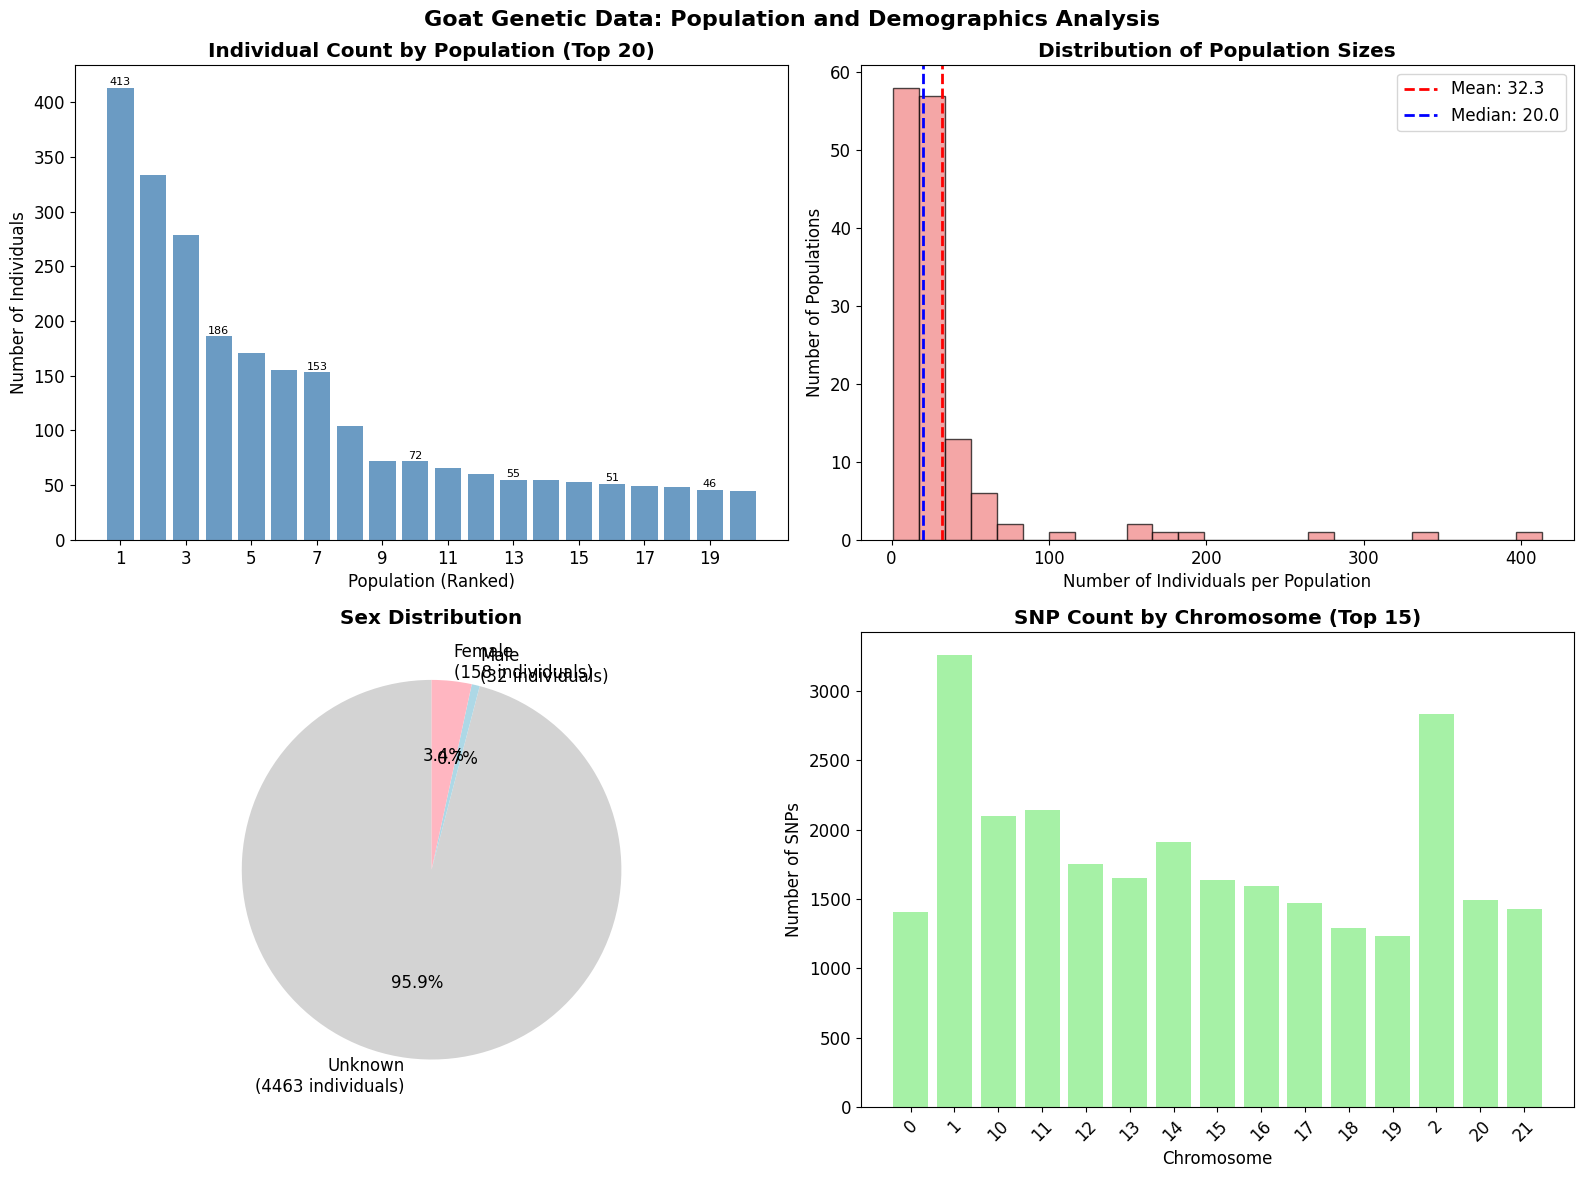

In [9]:

# EDA

# Prepare data for plotting
fid_values = goat_data.sample.fid.values
unique_populations, pop_counts = np.unique(fid_values, return_counts=True)
sorted_indices = np.argsort(pop_counts)[::-1]
sorted_pops = unique_populations[sorted_indices]
sorted_counts = pop_counts[sorted_indices]

gender_values = goat_data.sample.gender.values
unique_genders, gender_counts = np.unique(gender_values, return_counts=True)

chrom_values = goat_data.variant.chrom.values
unique_chroms, chrom_counts = np.unique(chrom_values, return_counts=True)
chrom_sorted_indices = np.argsort(unique_chroms)
sorted_chroms = unique_chroms[chrom_sorted_indices]
sorted_chrom_counts = chrom_counts[chrom_sorted_indices]

# Create the first EDA plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Goat Genetic Data: Population and Demographics Analysis',
             fontsize=16, fontweight='bold')

# Plot 1: Top 20 populations bar chart
ax1 = axes[0, 0]
top_20_pops = sorted_pops[:20]
top_20_counts = sorted_counts[:20]
bars = ax1.bar(range(len(top_20_pops)), top_20_counts,
               color='steelblue', alpha=0.8)
ax1.set_title('Individual Count by Population (Top 20)', fontweight='bold')
ax1.set_xlabel('Population (Ranked)')
ax1.set_ylabel('Number of Individuals')
ax1.set_xticks(range(0, len(top_20_pops), 2))
ax1.set_xticklabels([f'{i+1}' for i in range(0, len(top_20_pops), 2)])

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    if i % 3 == 0:  # Label every 3rd bar to avoid crowding
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Plot 2: Population size distribution histogram
ax2 = axes[0, 1]
ax2.hist(sorted_counts, bins=25, color='lightcoral', alpha=0.7,
         edgecolor='black')
ax2.axvline(np.mean(sorted_counts), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(sorted_counts):.1f}')
ax2.axvline(np.median(sorted_counts), color='blue', linestyle='--', linewidth=2,
           label=f'Median: {np.median(sorted_counts):.1f}')
ax2.set_title('Distribution of Population Sizes', fontweight='bold')
ax2.set_xlabel('Number of Individuals per Population')
ax2.set_ylabel('Number of Populations')
ax2.legend()

# Plot 3: Sex distribution pie chart
ax3 = axes[1, 0]
sex_labels = {'0': 'Unknown', '1': 'Male', '2': 'Female'}
sex_labels_plot = []
sex_colors = []
color_map = {'0': 'lightgray', '1': 'lightblue', '2': 'lightpink'}

for gender in unique_genders:
    sex_name = sex_labels.get(gender, f'Code {gender}')
    count = gender_counts[unique_genders == gender][0]
    sex_labels_plot.append(f'{sex_name}\n({count} individuals)')
    sex_colors.append(color_map.get(gender, 'gray'))

wedges, texts, autotexts = ax3.pie(gender_counts, labels=sex_labels_plot,
                                   autopct='%1.1f%%', colors=sex_colors,
                                   startangle=90)
ax3.set_title('Sex Distribution', fontweight='bold')

# Plot 4: SNPs per chromosome (top 15)
ax4 = axes[1, 1]
top_15_chroms = sorted_chroms[:15]
top_15_chrom_counts = sorted_chrom_counts[:15]
bars = ax4.bar(range(len(top_15_chroms)), top_15_chrom_counts,
               color='lightgreen', alpha=0.8)
ax4.set_title('SNP Count by Chromosome (Top 15)', fontweight='bold')
ax4.set_xlabel('Chromosome')
ax4.set_ylabel('Number of SNPs')
ax4.set_xticks(range(len(top_15_chroms)))
ax4.set_xticklabels([str(chrom) for chrom in top_15_chroms], rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Detailed Missingness Analysis

print(f"\n=== MISSINGNESS ANALYSIS ===")

genotype_matrix = goat_data.values  # Shape: (Individuals, SNPs)
total_elements = genotype_matrix.size
total_missing = np.isnan(genotype_matrix).sum()
overall_missing_rate = total_missing / total_elements

print(f"Overall missingness:")
print(f"- Matrix shape: {genotype_matrix.shape} (Individuals x SNPs)")
print(f"- Total possible genotypes: {total_elements:,}")
print(f"- Total missing genotypes: {total_missing:,}")
print(f"- Overall missing rate: {overall_missing_rate:.4f} ({overall_missing_rate*100:.2f}%)")

# Individual-level missingness (average across SNPs for each individual)
individual_missing = np.isnan(genotype_matrix).mean(axis=1)  # axis=1 for SNPs
print(f"\nIndividual-level missingness:")
print(f"- Mean missing rate: {individual_missing.mean():.4f} ({individual_missing.mean()*100:.2f}%)")
print(f"- Min missing rate: {individual_missing.min():.4f} ({individual_missing.min()*100:.2f}%)")
print(f"- Max missing rate: {individual_missing.max():.4f} ({individual_missing.max()*100:.2f}%)")
print(f"- Median missing rate: {np.median(individual_missing):.4f} ({np.median(individual_missing)*100:.2f}%)")
print(f"- Std deviation: {individual_missing.std():.4f}")

# SNP-level missingness (average across individuals for each SNP)
snp_missing = np.isnan(genotype_matrix).mean(axis=0)  # axis=0 for individuals
print(f"\nSNP-level missingness:")
print(f"- Mean missing rate: {snp_missing.mean():.4f} ({snp_missing.mean()*100:.2f}%)")
print(f"- Min missing rate: {snp_missing.min():.4f} ({snp_missing.min()*100:.2f}%)")
print(f"- Max missing rate: {snp_missing.max():.4f} ({snp_missing.max()*100:.2f}%)")
print(f"- Median missing rate: {np.median(snp_missing):.4f} ({np.median(snp_missing)*100:.2f}%)")
print(f"- Std deviation: {snp_missing.std():.4f}")

# High missingness patterns
high_missing_individuals = individual_missing > 0.1  # >10% missing
high_missing_snps = snp_missing > 0.1  # >10% missing

print(f"\nHigh missingness patterns:")
print(f"- Individuals with >10% missing: {high_missing_individuals.sum()} ({high_missing_individuals.sum()/len(individual_missing)*100:.1f}%)")
print(f"- SNPs with >10% missing: {high_missing_snps.sum()} ({high_missing_snps.sum()/len(snp_missing)*100:.1f}%)")

# Extreme missingness
very_high_missing_individuals = individual_missing > 0.2  # >20% missing
very_high_missing_snps = snp_missing > 0.2  # >20% missing

print(f"- Individuals with >20% missing: {very_high_missing_individuals.sum()} ({very_high_missing_individuals.sum()/len(individual_missing)*100:.1f}%)")
print(f"- SNPs with >20% missing: {very_high_missing_snps.sum()} ({very_high_missing_snps.sum()/len(snp_missing)*100:.1f}%)")

# Missingness by population (top 10 populations)
fid_values = goat_data.sample.fid.values
unique_populations, pop_counts = np.unique(fid_values, return_counts=True)
sorted_indices = np.argsort(pop_counts)[::-1]  # Sort by size
top_populations = unique_populations[sorted_indices[:10]]

print(f"\nMissingness by population (top 10 largest populations):")
for pop in top_populations:
    pop_mask = fid_values == pop
    pop_individuals = np.where(pop_mask)[0]
    pop_miss_rate = np.isnan(genotype_matrix[pop_individuals, :]).mean()
    pop_size = np.sum(pop_mask)
    print(f"- {pop}: {pop_miss_rate:.4f} ({pop_miss_rate*100:.2f}%, n={pop_size})")

print(f"\nData quality assessment:")
if overall_missing_rate < 0.01:
    quality = "excellent"
elif overall_missing_rate < 0.05:
    quality = "very good"
elif overall_missing_rate < 0.1:
    quality = "good"
elif overall_missing_rate < 0.2:
    quality = "moderate"
else:
    quality = "poor"

print(f"- Overall data quality: {quality}")
print(f"- Individual missingness is {'low' if individual_missing.mean() < 0.05 else 'moderate' if individual_missing.mean() < 0.1 else 'high'}")
print(f"- SNP missingness is {'low' if snp_missing.mean() < 0.05 else 'moderate' if snp_missing.mean() < 0.1 else 'high'}")
print(f"- Data appears suitable for genetic analysis after standard quality control")


=== MISSINGNESS ANALYSIS ===
Overall missingness:
- Matrix shape: (4653, 53347) (Individuals x SNPs)
- Total possible genotypes: 248,223,591
- Total missing genotypes: 7,510,010
- Overall missing rate: 0.0303 (3.03%)

Individual-level missingness:
- Mean missing rate: 0.0303 (3.03%)
- Min missing rate: 0.0033 (0.33%)
- Max missing rate: 0.7698 (76.98%)
- Median missing rate: 0.0234 (2.34%)
- Std deviation: 0.0505

SNP-level missingness:
- Mean missing rate: 0.0303 (3.03%)
- Min missing rate: 0.0017 (0.17%)
- Max missing rate: 1.0000 (100.00%)
- Median missing rate: 0.0090 (0.90%)
- Std deviation: 0.1048

High missingness patterns:
- Individuals with >10% missing: 125 (2.7%)
- SNPs with >10% missing: 2039 (3.8%)
- Individuals with >20% missing: 75 (1.6%)
- SNPs with >20% missing: 1688 (3.2%)

Missingness by population (top 10 largest populations):
- ANG: 0.0556 (5.56%, n=413)
- BOE: 0.0248 (2.48%, n=333)
- ALP: 0.0240 (2.40%, n=279)
- CRE: 0.0500 (5.00%, n=186)
- SAA: 0.0347 (3.47%, n=

Q3: PRINCIPAL COMPONENT ANALYSIS (PCA)
PCA complete! Result shape: (1500, 10)


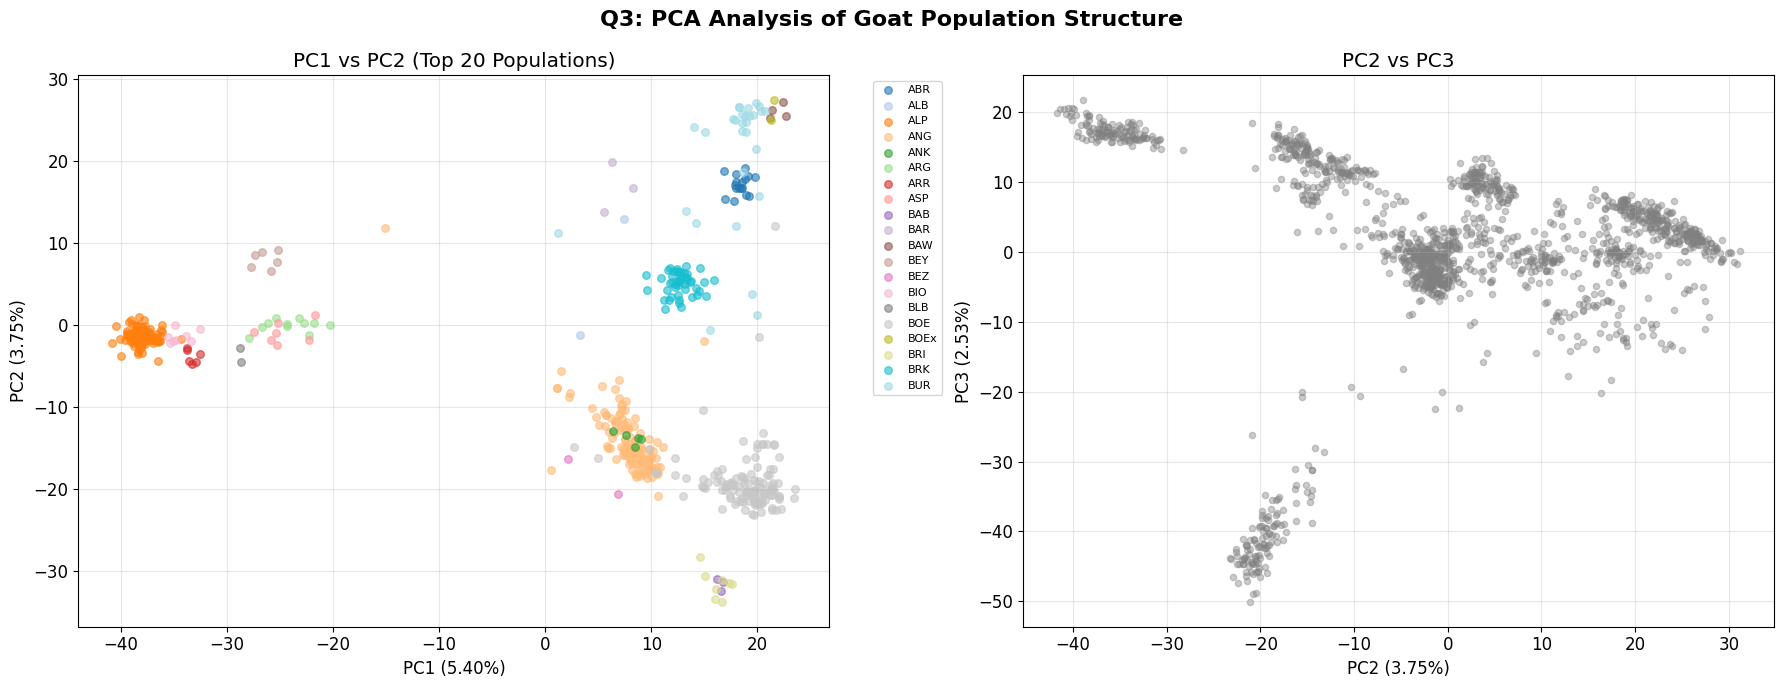

In [11]:
# Q3: PCA Analysis

print("=" * 70)
print("Q3: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 70)


# Sample 1500 individuals and 8000 SNPs for efficient PCA
np.random.seed(42)
n_ind = min(1500, goat_data.sample.shape[0])
n_snp = 8000

ind_indices = np.random.choice(goat_data.sample.shape[0], n_ind, replace=False)
snp_indices = np.random.choice(goat_data.variant.shape[0], n_snp, replace=False)

pca_data = goat_data.values[ind_indices, :][:, snp_indices]

# Get population labels
fid_pca = goat_data.sample.fid.values[ind_indices]

# Step 2: Handle missing values

imputer = SimpleImputer(strategy='mean')
pca_data_imputed = imputer.fit_transform(pca_data)

# Step 3: Standardize and run PCA
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data_imputed)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(pca_data_scaled)
print(f"PCA complete! Result shape: {pca_result.shape}")


cumvar = np.cumsum(pca.explained_variance_ratio_)


# Get unique populations and assign colors
unique_pops = np.unique(fid_pca)
n_pops = len(unique_pops)
colors_map = plt.cm.tab20(np.linspace(0, 1, min(n_pops, 20)))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Q3: PCA Analysis of Goat Population Structure', fontsize=16, fontweight='bold')

# Plot 1: PC1 vs PC2 with top 20 populations
ax1 = axes[0]
for i, pop in enumerate(unique_pops[:20]):  # Top 20 populations
    mask = fid_pca == pop
    ax1.scatter(pca_result[mask, 0], pca_result[mask, 1],
               c=[colors_map[i]], label=pop, alpha=0.6, s=30)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
ax1.set_title('PC1 vs PC2 (Top 20 Populations)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: PC2 vs PC3
ax2 = axes[1]
ax2.scatter(pca_result[:, 1], pca_result[:, 2], c='gray', alpha=0.4, s=20)
ax2.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)')
ax2.set_title('PC2 vs PC3')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()